In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from encoding_information.bsccm_utils import *
from encoding_information.plot_utils import *
from encoding_information.bsccm_utils import *
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-30 20:34:16.992990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


## Estimate stationary gaussian processes and draw samples from them

In [2]:
# images used to generate the covariance matrix
num_images = 10000
num_patches = 10000
edge_crop = 24

patch_size = 50 # the size of patches to estimate the covariance matrix from
sample_size = 128 - 2 * edge_crop # the size of the samples to generate
num_samples = 10

# patch_size = 5
# sample_size = 10

photons_per_pixel = 300

channels = ['LED119', 'DPC_Right', 'Brightfield']
eigenvalue_floors = [1e-2, 1e-2, 1e2]
# channels = ['LED119', 'DPC_Right']
# channels = ['LED119']


image_samples_gp = {}
image_samples_pcnn = {}
noisy_patches_by_channel = {}
images_by_channel = {}

for channel_index, channel in tqdm(enumerate(channels), desc='Fitting models and sampling'):
    images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
    images_by_channel[channel] = images[:num_samples * 10]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    images = None # save memory

    print('getting patches')
    noisy_patches = extract_patches(noisy_images, patch_size=patch_size, num_patches=num_patches, seed=1234)
    noisy_patches_by_channel[channel] = noisy_patches[: num_samples * 10] # for display

    print('fitting stationary GP')
    gp = StationaryGaussianProcess(noisy_patches, eigenvalue_floor=eigenvalue_floors[channel_index])
    _ = gp.fit(noisy_patches, verbose=True)
    cov_mat = gp.get_cov_mat()

    print('fitting PixelCNN')
    pcnn = PixelCNN()
    pcnn.fit(noisy_patches, max_epochs=25, verbose=True)

    print('generating samples for PixelCNN')
    image_samples_pcnn[channel] = pcnn.generate_samples(num_samples, sample_size, seed=channel_index * 1000, verbose=True)

    print('generating samples for stationary GP')
    image_samples_gp[channel] = gp.generate_samples(num_samples, sample_size,seed=channel_index * 1000, verbose=True)


Fitting models and sampling: 0it [00:00, ?it/s]

getting patches
fitting stationary GP


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:41: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.1


2023-10-30 20:37:33.406648: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 18.18



Epoch 1: 100%|█████████████████████████████| 1/1 [01:15<00:00, 75.54s/it]


Epoch 1: validation NLL: 4.61



Epoch 2: 100%|█████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch 2: validation NLL: 4.59



Epoch 3: 100%|█████████████████████████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch 3: validation NLL: 4.59



Epoch 4: 100%|█████████████████████████████| 1/1 [00:00<00:00,  4.96it/s]


Epoch 4: validation NLL: 4.59



Epoch 5: 100%|█████████████████████████████| 1/1 [00:00<00:00,  4.96it/s]


Epoch 5: validation NLL: 4.59



Epoch 6: 100%|█████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch 6: validation NLL: 4.58



Epoch 7: 100%|█████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


Epoch 7: validation NLL: 4.58



Epoch 8: 100%|█████████████████████████████| 1/1 [00:00<00:00,  4.93it/s]


Epoch 8: validation NLL: 4.58



Epoch 9: 100%|█████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


Epoch 9: validation NLL: 4.58



Epoch 10: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


Epoch 10: validation NLL: 4.58



Epoch 11: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.91it/s]


Epoch 11: validation NLL: 4.58



Epoch 12: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.96it/s]


Epoch 12: validation NLL: 4.58



Epoch 13: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]


Epoch 13: validation NLL: 4.58



Epoch 14: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.98it/s]


Epoch 14: validation NLL: 4.58



Epoch 15: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch 15: validation NLL: 4.58



Epoch 16: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]


Epoch 16: validation NLL: 4.58



Epoch 17: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


Epoch 17: validation NLL: 4.58



Epoch 18: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.94it/s]


Epoch 18: validation NLL: 4.58



Epoch 19: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Epoch 19: validation NLL: 4.58



Epoch 20: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.01it/s]


Epoch 20: validation NLL: 4.58



Epoch 21: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.94it/s]


Epoch 21: validation NLL: 4.58



Epoch 22: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


Epoch 22: validation NLL: 4.58



Epoch 23: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]


Epoch 23: validation NLL: 4.58



Epoch 24: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]


Epoch 24: validation NLL: 4.58



Epoch 25: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


Epoch 25: validation NLL: 4.58



Epoch 26: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch 26: validation NLL: 4.58



Epoch 27: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.87it/s]


Epoch 27: validation NLL: 4.58



Epoch 28: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


Epoch 28: validation NLL: 4.58



Epoch 29: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


Epoch 29: validation NLL: 4.58



Epoch 30: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch 30: validation NLL: 4.58



Epoch 31: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch 31: validation NLL: 4.58



Epoch 32: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


Epoch 32: validation NLL: 4.58



Epoch 33: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.94it/s]


Epoch 33: validation NLL: 4.58



Epoch 34: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch 34: validation NLL: 4.58



Epoch 35: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.89it/s]


Epoch 35: validation NLL: 4.58



Epoch 36: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch 36: validation NLL: 4.58



Epoch 37: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.86it/s]


Epoch 37: validation NLL: 4.58



Epoch 38: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch 38: validation NLL: 4.58



Epoch 39: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.94it/s]


Epoch 39: validation NLL: 4.58



Epoch 40: 100%|████████████████████████████| 1/1 [00:00<00:00,  4.89it/s]


Epoch 40: validation NLL: 4.58
fitting PixelCNN
Initial validation NLL: 69.86



Epoch 1: 100%|█████████████████████████| 100/100 [00:28<00:00,  3.46it/s]


Epoch 1: validation NLL: 4.82



Epoch 2: 100%|█████████████████████████| 100/100 [00:09<00:00, 10.58it/s]


Epoch 2: validation NLL: 4.58



Epoch 3: 100%|█████████████████████████| 100/100 [00:09<00:00, 10.84it/s]


Epoch 3: validation NLL: 4.57



Epoch 4: 100%|█████████████████████████| 100/100 [00:09<00:00, 10.64it/s]


Epoch 4: validation NLL: 4.56



Epoch 5: 100%|█████████████████████████| 100/100 [00:09<00:00, 10.81it/s]


Epoch 5: validation NLL: 4.57



Epoch 6: 100%|█████████████████████████| 100/100 [00:09<00:00, 10.66it/s]


Epoch 6: validation NLL: 4.58



Epoch 7: 100%|█████████████████████████| 100/100 [00:09<00:00, 10.69it/s]


Epoch 7: validation NLL: 4.57



Epoch 8: 100%|█████████████████████████| 100/100 [00:09<00:00, 10.69it/s]


Epoch 8: validation NLL: 4.54



Epoch 9: 100%|█████████████████████████| 100/100 [00:09<00:00, 10.72it/s]


Epoch 9: validation NLL: 4.54



Epoch 10: 100%|████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


Epoch 10: validation NLL: 4.62



Epoch 11: 100%|████████████████████████| 100/100 [00:09<00:00, 10.73it/s]


Epoch 11: validation NLL: 4.53



Epoch 12: 100%|████████████████████████| 100/100 [00:09<00:00, 10.66it/s]


Epoch 12: validation NLL: 4.53



Epoch 13: 100%|████████████████████████| 100/100 [00:09<00:00, 10.83it/s]


Epoch 13: validation NLL: 4.54



Epoch 14: 100%|████████████████████████| 100/100 [00:09<00:00, 10.76it/s]


Epoch 14: validation NLL: 4.53



Epoch 15: 100%|████████████████████████| 100/100 [00:09<00:00, 10.55it/s]


Epoch 15: validation NLL: 4.54



Epoch 16: 100%|████████████████████████| 100/100 [00:09<00:00, 10.78it/s]


Epoch 16: validation NLL: 4.52



Epoch 17: 100%|████████████████████████| 100/100 [00:09<00:00, 10.66it/s]


Epoch 17: validation NLL: 4.52



Epoch 18: 100%|████████████████████████| 100/100 [00:09<00:00, 10.65it/s]


Epoch 18: validation NLL: 4.53



Epoch 19: 100%|████████████████████████| 100/100 [00:09<00:00, 10.56it/s]


Epoch 19: validation NLL: 4.53



Epoch 20: 100%|████████████████████████| 100/100 [00:09<00:00, 10.57it/s]


Epoch 20: validation NLL: 4.52



Epoch 21: 100%|████████████████████████| 100/100 [00:09<00:00, 10.76it/s]


Epoch 21: validation NLL: 4.51



Epoch 22: 100%|████████████████████████| 100/100 [00:09<00:00, 10.64it/s]


Epoch 22: validation NLL: 4.51



Epoch 23: 100%|████████████████████████| 100/100 [00:09<00:00, 10.80it/s]


Epoch 23: validation NLL: 4.51



Epoch 24: 100%|████████████████████████| 100/100 [00:09<00:00, 10.55it/s]


Epoch 24: validation NLL: 4.52



Epoch 25: 100%|████████████████████████| 100/100 [00:09<00:00, 10.62it/s]


Epoch 25: validation NLL: 4.52
generating samples for PixelCNN



Generating PixelCNN samples: 100%|███████| 80/80 [41:41<00:00, 31.27s/it]


generating samples for stationary GP



precomputing masks and variances: 100%|██| 80/80 [04:07<00:00,  3.10s/it]


generating stationary gaussian process samples



generating samples: 100%|████████████████| 80/80 [01:44<00:00,  1.30s/it]
Fitting models and sampling: 1it [57:12, 3432.79s/it]

getting patches
fitting stationary GP
Initial validation NLL: 4.43



Epoch 1: 100%|█████████████████████████████| 1/1 [00:48<00:00, 48.47s/it]


Epoch 1: validation NLL: 4.43



Epoch 2: 100%|█████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Epoch 2: validation NLL: 4.43



Epoch 3: 100%|█████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Epoch 3: validation NLL: 4.43



Epoch 4: 100%|█████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch 4: validation NLL: 4.43



Epoch 5: 100%|█████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Epoch 5: validation NLL: 4.43



Epoch 6: 100%|█████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]


Epoch 6: validation NLL: 4.43



Epoch 7: 100%|█████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch 7: validation NLL: 4.43



Epoch 8: 100%|█████████████████████████████| 1/1 [00:00<00:00,  5.09it/s]


Epoch 8: validation NLL: 4.43



Epoch 9: 100%|█████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]


Epoch 9: validation NLL: 4.43
fitting PixelCNN
Initial validation NLL: 44.81



Epoch 1: 100%|█████████████████████████| 100/100 [00:13<00:00,  7.58it/s]


Epoch 1: validation NLL: 4.45



Epoch 2: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.24it/s]


Epoch 2: validation NLL: 4.41



Epoch 3: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.44it/s]


Epoch 3: validation NLL: 4.40



Epoch 4: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.40it/s]


Epoch 4: validation NLL: 4.40



Epoch 5: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.33it/s]


Epoch 5: validation NLL: 4.40



Epoch 6: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.28it/s]


Epoch 6: validation NLL: 4.40



Epoch 7: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.33it/s]


Epoch 7: validation NLL: 4.40



Epoch 8: 100%|█████████████████████████| 100/100 [00:08<00:00, 12.12it/s]


Epoch 8: validation NLL: 4.39



Epoch 9: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.45it/s]


Epoch 9: validation NLL: 4.39



Epoch 10: 100%|████████████████████████| 100/100 [00:08<00:00, 11.25it/s]


Epoch 10: validation NLL: 4.39



Epoch 11: 100%|████████████████████████| 100/100 [00:08<00:00, 11.29it/s]


Epoch 11: validation NLL: 4.40



Epoch 12: 100%|████████████████████████| 100/100 [00:08<00:00, 11.26it/s]


Epoch 12: validation NLL: 4.39



Epoch 13: 100%|████████████████████████| 100/100 [00:08<00:00, 11.27it/s]


Epoch 13: validation NLL: 4.39



Epoch 14: 100%|████████████████████████| 100/100 [00:08<00:00, 11.27it/s]


Epoch 14: validation NLL: 4.39



Epoch 15: 100%|████████████████████████| 100/100 [00:08<00:00, 11.29it/s]


Epoch 15: validation NLL: 4.40



Epoch 16: 100%|████████████████████████| 100/100 [00:08<00:00, 11.29it/s]


Epoch 16: validation NLL: 4.38



Epoch 17: 100%|████████████████████████| 100/100 [00:08<00:00, 11.24it/s]


Epoch 17: validation NLL: 4.38



Epoch 18: 100%|████████████████████████| 100/100 [00:08<00:00, 11.33it/s]


Epoch 18: validation NLL: 4.39



Epoch 19: 100%|████████████████████████| 100/100 [00:08<00:00, 11.24it/s]


Epoch 19: validation NLL: 4.38



Epoch 20: 100%|████████████████████████| 100/100 [00:08<00:00, 11.23it/s]


Epoch 20: validation NLL: 4.38



Epoch 21: 100%|████████████████████████| 100/100 [00:08<00:00, 11.13it/s]


Epoch 21: validation NLL: 4.38



Epoch 22: 100%|████████████████████████| 100/100 [00:09<00:00, 11.10it/s]


Epoch 22: validation NLL: 4.38



Epoch 23: 100%|████████████████████████| 100/100 [00:08<00:00, 11.14it/s]


Epoch 23: validation NLL: 4.38



Epoch 24: 100%|████████████████████████| 100/100 [00:08<00:00, 11.21it/s]


Epoch 24: validation NLL: 4.38



Epoch 25: 100%|████████████████████████| 100/100 [00:08<00:00, 11.15it/s]


Epoch 25: validation NLL: 4.39
generating samples for PixelCNN



Generating PixelCNN samples: 100%|███████| 80/80 [37:52<00:00, 28.40s/it]


generating samples for stationary GP



precomputing masks and variances: 100%|██| 80/80 [02:40<00:00,  2.01s/it]


generating stationary gaussian process samples



generating samples: 100%|████████████████| 80/80 [01:18<00:00,  1.02it/s]
Fitting models and sampling: 2it [1:46:09, 3140.92s/it]

getting patches
fitting stationary GP
Initial validation NLL: 4.33



Epoch 1: 100%|█████████████████████████████| 1/1 [00:46<00:00, 46.09s/it]
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/image_distribution_models.py:199: UserWarning: NaN encountered in validation loss. Stopping early.
  warnings.warn('NaN encountered in validation loss. Stopping early.')


fitting PixelCNN
Initial validation NLL: 18.20



Epoch 1: 100%|█████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


Epoch 1: validation NLL: 4.30



Epoch 2: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.54it/s]


Epoch 2: validation NLL: 4.29



Epoch 3: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.47it/s]


Epoch 3: validation NLL: 4.29



Epoch 4: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.45it/s]


Epoch 4: validation NLL: 4.29



Epoch 5: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.48it/s]


Epoch 5: validation NLL: 4.29



Epoch 6: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.44it/s]


Epoch 6: validation NLL: 4.29



Epoch 7: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.42it/s]


Epoch 7: validation NLL: 4.29



Epoch 8: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.43it/s]


Epoch 8: validation NLL: 4.29



Epoch 9: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.35it/s]


Epoch 9: validation NLL: 4.29



Epoch 10: 100%|████████████████████████| 100/100 [00:08<00:00, 11.37it/s]


Epoch 10: validation NLL: 4.29



Epoch 11: 100%|████████████████████████| 100/100 [00:08<00:00, 11.32it/s]


Epoch 11: validation NLL: 4.29



Epoch 12: 100%|████████████████████████| 100/100 [00:08<00:00, 11.35it/s]


Epoch 12: validation NLL: 4.29



Epoch 13: 100%|████████████████████████| 100/100 [00:08<00:00, 11.29it/s]


Epoch 13: validation NLL: 4.29



Epoch 14: 100%|████████████████████████| 100/100 [00:08<00:00, 11.25it/s]


Epoch 14: validation NLL: 4.29



Epoch 15: 100%|████████████████████████| 100/100 [00:08<00:00, 11.34it/s]


Epoch 15: validation NLL: 4.29



Epoch 16: 100%|████████████████████████| 100/100 [00:08<00:00, 11.29it/s]


Epoch 16: validation NLL: 4.29



Epoch 17: 100%|████████████████████████| 100/100 [00:08<00:00, 11.29it/s]


Epoch 17: validation NLL: 4.29



Epoch 18: 100%|████████████████████████| 100/100 [00:08<00:00, 11.26it/s]


Epoch 18: validation NLL: 4.29



Epoch 19: 100%|████████████████████████| 100/100 [00:08<00:00, 11.23it/s]


Epoch 19: validation NLL: 4.29



Epoch 20: 100%|████████████████████████| 100/100 [00:08<00:00, 11.31it/s]


Epoch 20: validation NLL: 4.29



Epoch 21: 100%|████████████████████████| 100/100 [00:08<00:00, 11.28it/s]


Epoch 21: validation NLL: 4.29



Epoch 22: 100%|████████████████████████| 100/100 [00:08<00:00, 11.23it/s]


Epoch 22: validation NLL: 4.29



Epoch 23: 100%|████████████████████████| 100/100 [00:08<00:00, 11.22it/s]


Epoch 23: validation NLL: 4.29



Epoch 24: 100%|████████████████████████| 100/100 [00:08<00:00, 11.19it/s]


Epoch 24: validation NLL: 4.29



Epoch 25: 100%|████████████████████████| 100/100 [00:08<00:00, 11.23it/s]


Epoch 25: validation NLL: 4.29
generating samples for PixelCNN



Generating PixelCNN samples: 100%|███████| 80/80 [34:51<00:00, 26.15s/it]


generating samples for stationary GP



precomputing masks and variances: 100%|██| 80/80 [04:54<00:00,  3.69s/it]


generating stationary gaussian process samples



generating samples: 100%|████████████████| 80/80 [01:35<00:00,  1.20s/it]
Fitting models and sampling: 3it [2:34:18, 3086.02s/it]


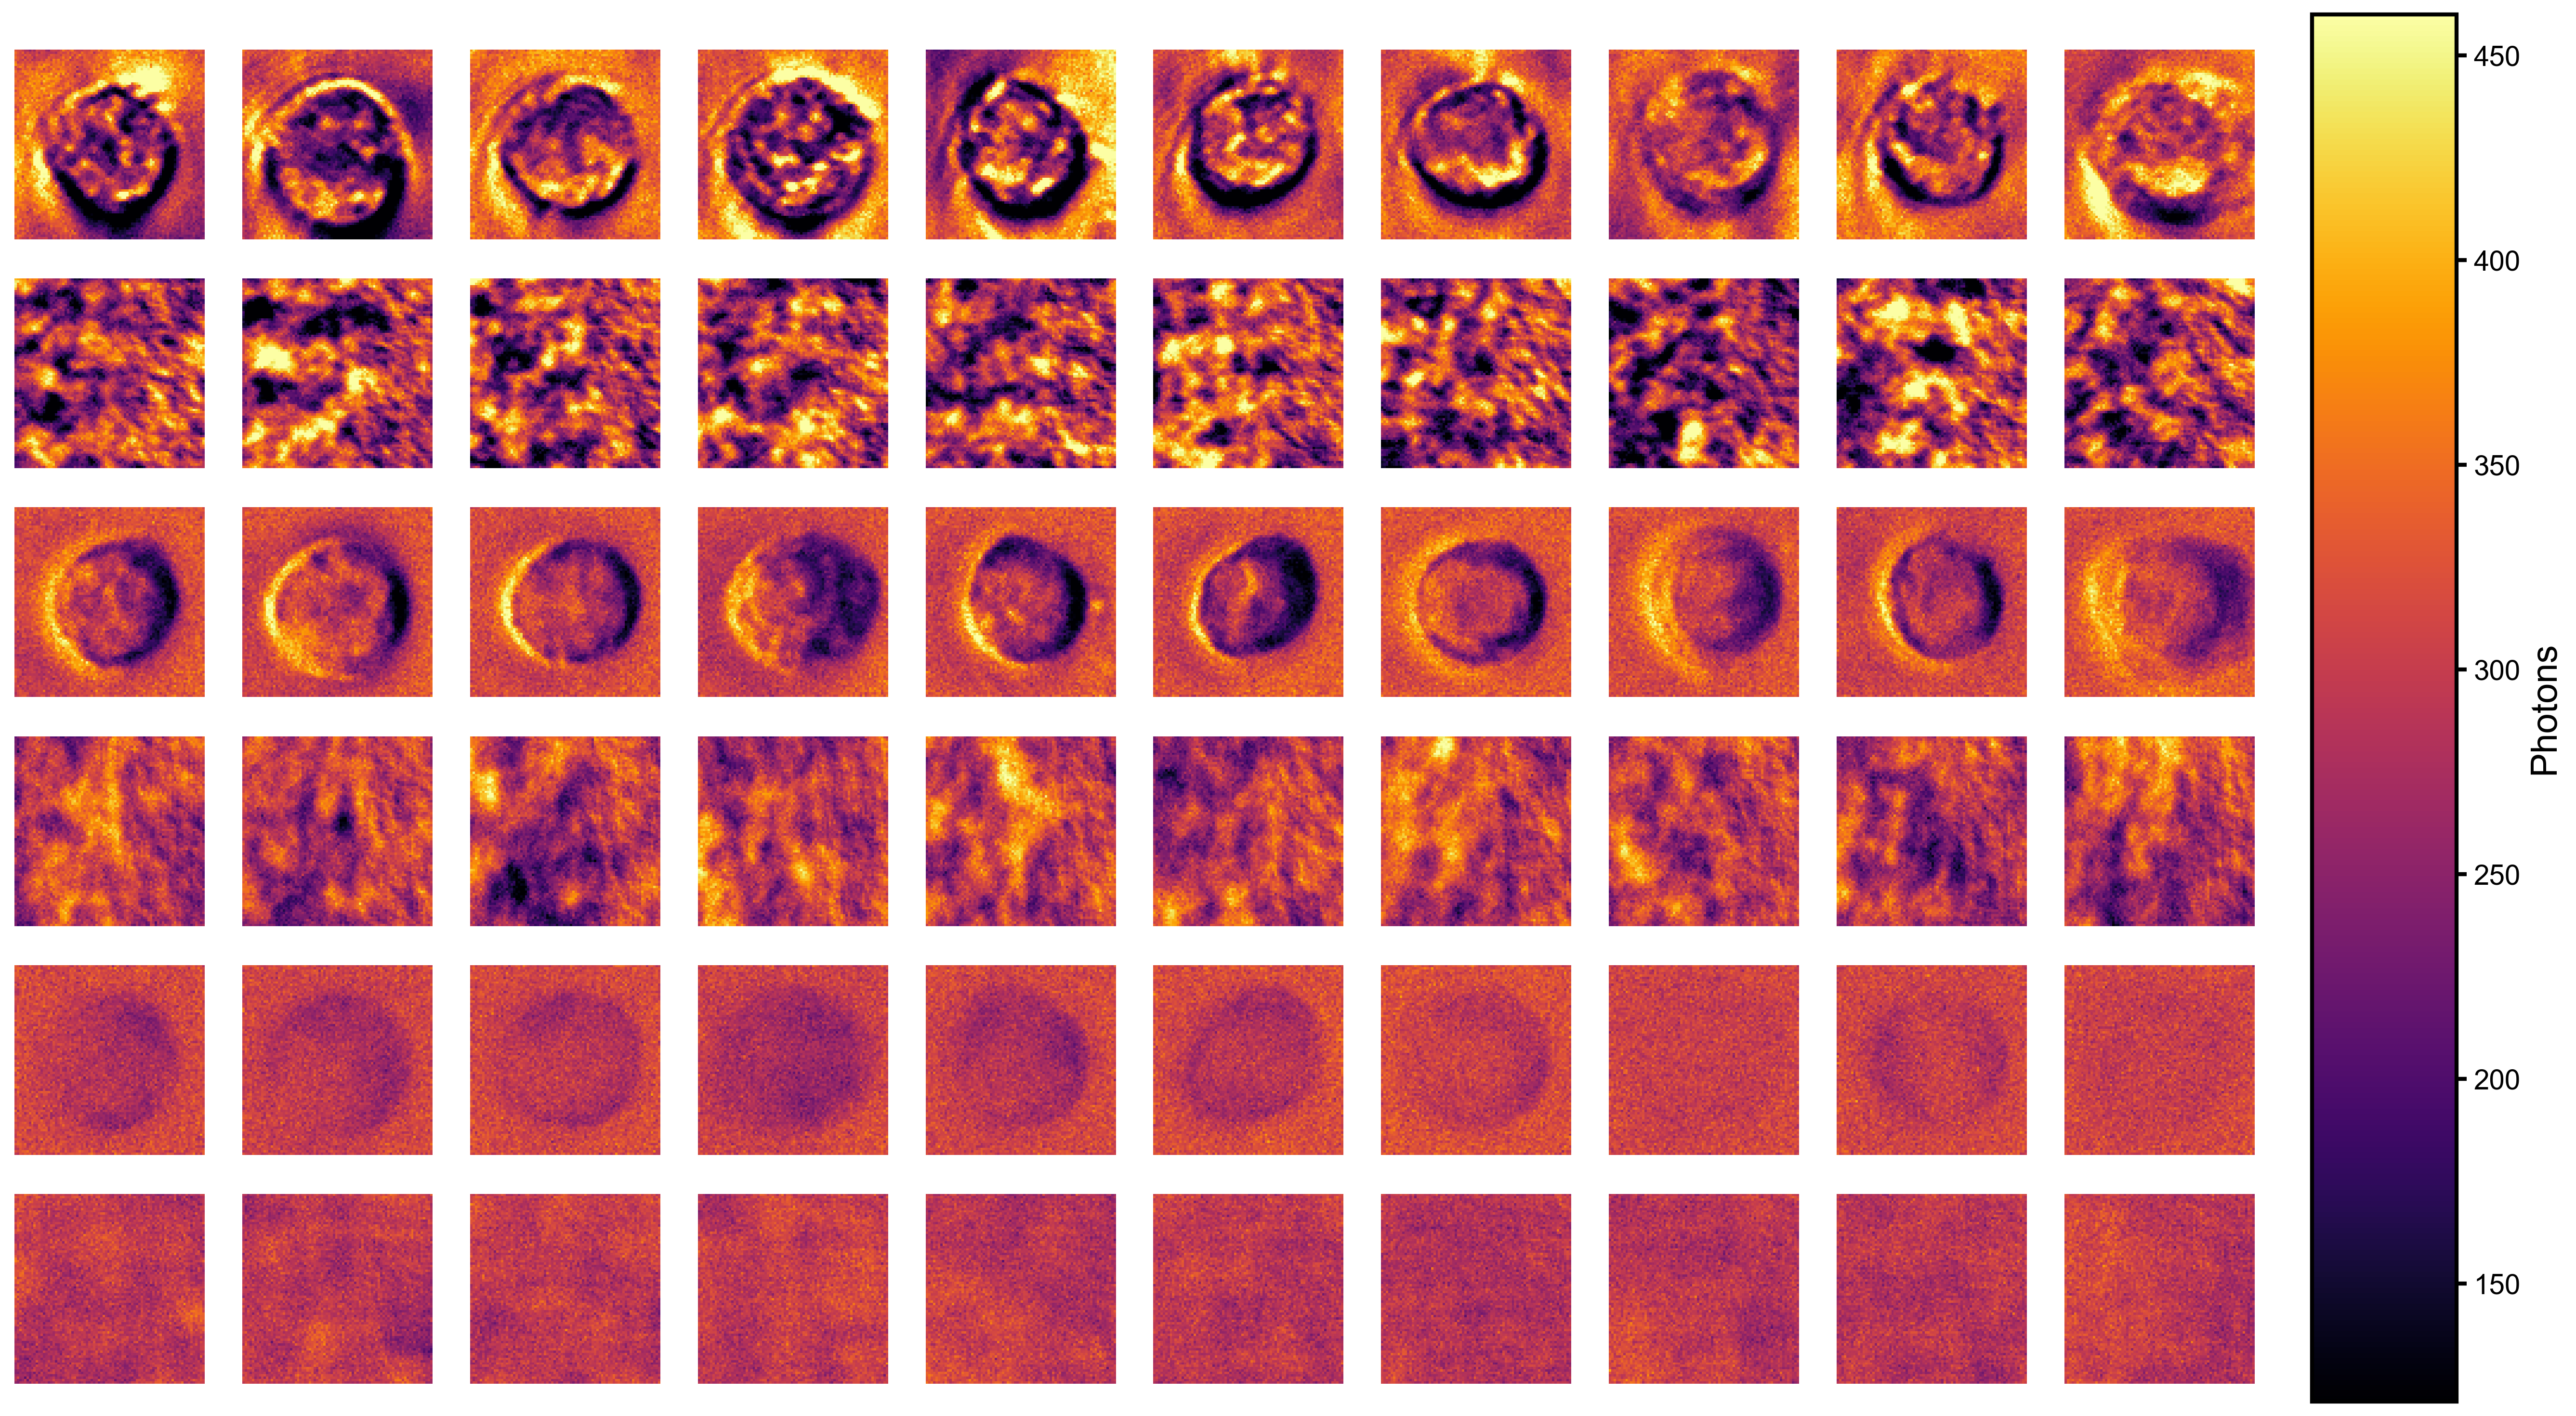

In [3]:
image_samples = image_samples_gp

# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
vmin = np.percentile(all_pix, 1)
vmax = np.percentile(all_pix, 99)
# vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = onp.array(images_by_channel[channel])[[1, 3, 19, 5, 11, 22, 23, 24, 25, 26, 27, 28, 29 , 30]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

# fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples_gp' + '.pdf', transparent=True)

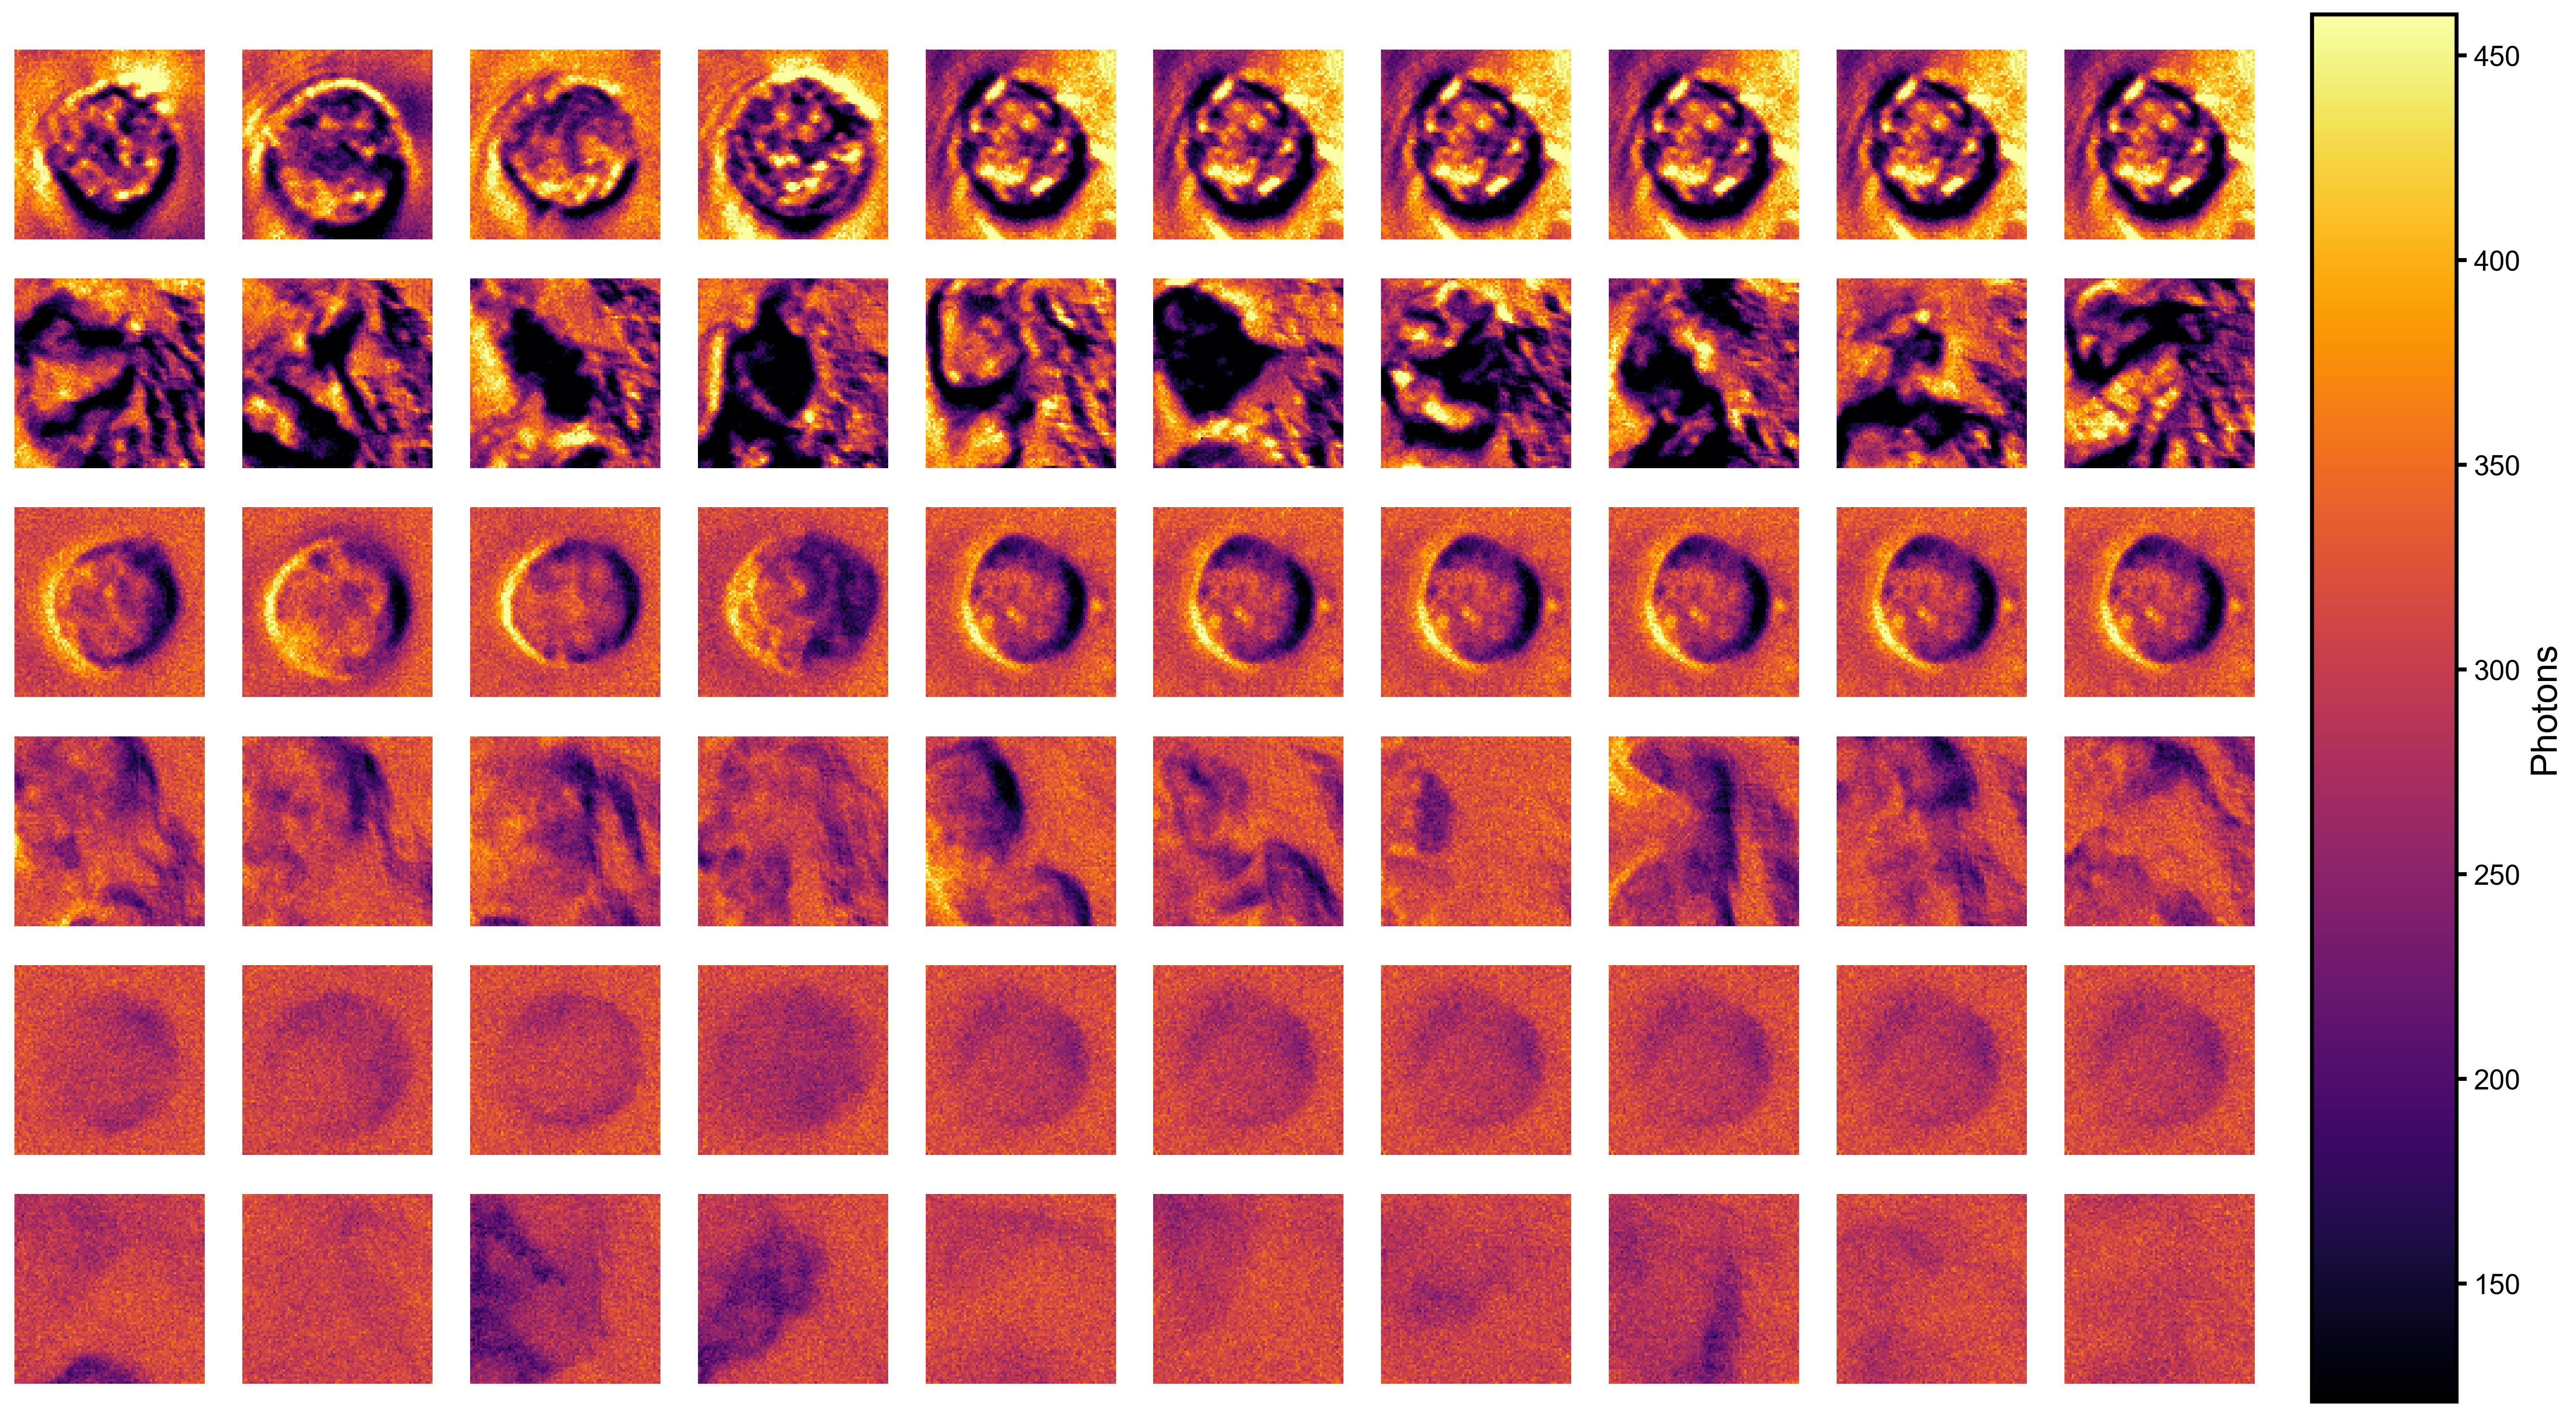

In [4]:
image_samples = image_samples_pcnn

# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
vmin = np.percentile(all_pix, 1)
vmax = np.percentile(all_pix, 99)
# vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = onp.array(images_by_channel[channel])[[1, 3, 19, 5, 11, 22, 23, 24, 25, 26, 27, 28, 29 , 30]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

# fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples_pixel_cnn' + '.pdf', transparent=True)